In [1]:
# To avoid openmp conflicts (use TBB for MacOSX / TBB or GNU for Linux)
%env MKL_THREADING_LAYER=TBB

env: MKL_THREADING_LAYER=TBB


In [2]:
import pylab as pl
import numpy as np
import pandas as pd
from tqdm import tqdm
import os, sys

In [3]:
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

In [4]:
from sklearn.decomposition import PCA
from umap import UMAP 

/Users/ascaife/SRC/GITHUB/MIGHTEE-FR/venv/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [5]:
from byol.utilities import embed_dataset
from byol.datasets import RGZ108k
from byol.datasets import MBFRFull, MBHybrid, MBFRConfident, MBFRUncertain
from byol.models import BYOL

---

### Set-up steps:

Define location of checkpoint file for pre-trained BYOL model:

In [6]:
ckpt = '/Users/ascaife/SRC/GITHUB/byol/byol/byol.ckpt'

Load model from checkpoint (pre-trained weights):

In [7]:
byol = BYOL.load_from_checkpoint(ckpt)
byol.eval()
encoder = byol.encoder
encoder.eval()
config = byol.config
mu, sig = config["data"]["mu"], config["data"]["sig"]

Lightning automatically upgraded your loaded checkpoint from v1.5.6 to v2.3.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../byol/byol/byol.ckpt`


Define a class of functions to encode the data through the model and perform dimensionality reduction:

In [8]:
class Reducer:
    
    def __init__(self, encoder, PCA_COMPONENTS, UMAP_N_NEIGHBOURS, UMAP_MIN_DIST, METRIC, embedding=None, seed=42):
        
        self.encoder = encoder
        self.pca = PCA(n_components=PCA_COMPONENTS, random_state=seed)
        self.umap = UMAP(
            n_components=2,
            n_neighbors=UMAP_N_NEIGHBOURS,
            min_dist=UMAP_MIN_DIST,
            metric=METRIC,
            random_state=seed,
        )

        if embedding is not None:
            if not os.path.exists(embedding):
                print("Specified embedding file does not exist - will compute embedding")
                self.embedded = False
            else:
                self.filename = embedding
                self.embedded = True
        else:
            self.embedded = False

    def read_file(self):

        print("Reading embedding from file: {}".format(self.filename))
        
        df = pd.read_parquet(self.filename)
        features = df[[f"feat_{i}" for i in range(512)]].values
        if 'target' in df.columns:
            targets = df["target"].values
        else:
            targets = np.ones(features.shape[0])
        
        return features, targets

    def write_file(self, filename):

        cols = [f"feat_{i}" for i in range(512)]
        print(self.features.shape, self.targets.shape)
        df = pd.DataFrame(data=self.features, columns=cols)
        df.to_parquet(filename)
        
        return 
        
    def embed_dataset(self, data, batch_size=400):
        train_loader = DataLoader(data, batch_size, shuffle=False)
        device = next(encoder.parameters()).device
        feature_bank = []
        target_bank = []
        for data in tqdm(train_loader):
            #print(len(data), data[0].shape)
            # Load data and move to correct device
            if len(data)>2:
                x = data
            else:
                x, y = data
                
            x_enc = encoder(x.to(device))

            feature_bank.append(x_enc.squeeze().detach().cpu())
            #target_bank.append(y['size'].detach().cpu())
            
        # Save full feature bank for validation epoch
        features = torch.cat(feature_bank)
        #targets = torch.cat(target_bank)
        targets = np.ones(features.shape[0])
        
        return features, targets

    def fit(self, data=None):
        
        print("Fitting reducer")

        if data!=None: features, targets = self.embed_dataset(data)
        if data==None and self.embedded: features, targets = self.read_file()
        if data==None and not self.embedded:
            print("No data/embedding provided - exiting")
            return
         
        self.features = features
        self.targets = targets

        self.pca.fit(self.features)
        self.umap.fit(self.pca.transform(self.features))

        return

    def transform(self, data=None):
        
        print("Performing transformation")

        if data!=None: 
            x, _ = self.embed_dataset(data)
        elif data==None and hasattr(self, 'features'): 
            x = self.features
        elif data==None and not hasattr(self, 'features') and self.embedded: 
            x, _ = self.read_file()  
        elif data==None and not hasattr(self, 'features') and not self.embedded: 
            print("No data/embedding provided - exiting")
            return
        
        x = self.pca.transform(x)
        x = self.umap.transform(x)
        return x

    def transform_pca(self, data):
        x, _ = self.embed_dataset(data)
        x = self.pca.transform(x)
        return x

Load the datasets (RGZ and MiraBest):

In [9]:
paths={}
paths["rgz"] = "/Users/ascaife/SRC/GITHUB/_data/rgz"
paths["mb"] = "/Users/ascaife/SRC/GITHUB/_data/mb"

In [10]:
transform = T.Compose(
    [
        T.CenterCrop(70),
        T.ToTensor(),
        T.Normalize((mu,), (sig,)),
    ]
)

rgz = RGZ108k(
    paths["rgz"],
    train=True,
    transform=transform,
    download=False,
    remove_duplicates=False,
    cut_threshold=25,           # remove sources below this size threshold [arcsec]
    mb_cut=True,                # remove sources that are also in MiraBest
    )

mb = MBFRFull(paths["mb"], 
              train=True, 
              transform=transform, 
              download=False, 
              aug_type="torchvision"
             )

Removing 49722 samples below angular size threshold.
Removed 1420 MiraBest samples from RGZ
(54858, 150, 150, 1)


---

### RGZ representation coloured by source angular size (Fig 2 in Inigo's paper):

Define the hyper-parameters for dimensionality reduction:

In [11]:
PCA_COMPONENTS = 200
UMAP_N_NEIGHBOURS = 75
UMAP_MIN_DIST = 0.01
METRIC = "cosine"

In [12]:
embedding = 'rgz_embedding_25.parquet'

Fit the dimensionality reduction and transform the data through it (takes about 20 mins on CPU):

In [13]:
reducer = Reducer(encoder, PCA_COMPONENTS, UMAP_N_NEIGHBOURS, UMAP_MIN_DIST, METRIC, embedding='rgz_embedding_25.parquet')
reducer.fit()

Fitting reducer
Reading embedding from file: rgz_embedding_25.parquet


/Users/ascaife/SRC/GITHUB/MIGHTEE-FR/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [14]:
X_umap = reducer.transform()

Performing transformation


Write the embedding to disk:

In [15]:
#reducer.write_file("rgz_embedding_25.parquet")

---
### RGZ representation coloured by extent (Fig 2 in Inigo's paper):

In [16]:
alpha = 0.6
marker_size = 0.1
fig_size = (10 / 3, 3)
fontsize = 9
marker = "o"

Get the label info for all the embedded data samples:

In [17]:
data_loader = DataLoader(rgz, batch_size=len(rgz), shuffle=False)
_, y = next(iter(data_loader))

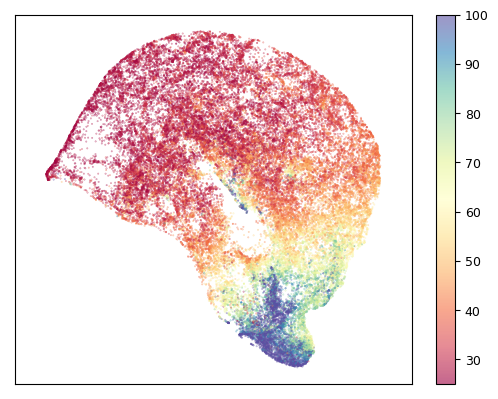

In [18]:
fig, ax = pl.subplots()
#fig.set_size_inches(fig_size)

scatter = ax.scatter(
    X_umap[:, 0],
    X_umap[:, 1],
#    c=reducer.targets,
    c=y["size"].numpy(),
    cmap="Spectral",
    s=marker_size,
    marker=marker,
    vmin=25,
    vmax=100,
    alpha=alpha,
)
pl.gca().set_aspect("equal", "datalim")
cbar = fig.colorbar(scatter)
cbar.ax.tick_params(labelsize=fontsize)
ax.set_xlabel("umap x", fontsize=fontsize)
ax.set_ylabel("umap y", fontsize=fontsize)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig.savefig("byol_umap_rgz.png", bbox_inches="tight", pad_inches=0.05, dpi=600)

---

### RGZ & MB representation (Fig 3 in Inigo's paper):

In [19]:
rgz_umap = reducer.transform()
mb_umap = reducer.transform(mb)

Performing transformation
Performing transformation


100%|█████████████████████████████████████████████| 3/3 [00:13<00:00,  4.45s/it]


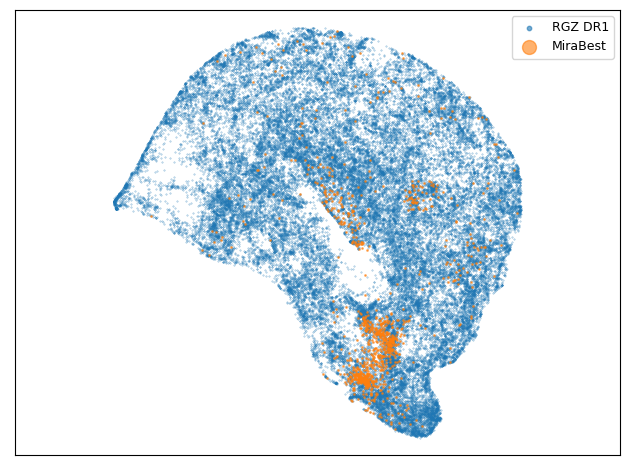

In [21]:
fig, ax = pl.subplots()
#fig.set_size_inches(fig_size)

ax.scatter(rgz_umap[:, 0], rgz_umap[:, 1], label="RGZ DR1", marker=marker, s=marker_size, alpha=alpha)
ax.scatter(mb_umap[:, 0], mb_umap[:, 1], label="MiraBest", marker=marker, s=10*marker_size, alpha=alpha)

pl.gca().set_aspect("equal", "datalim")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_xlabel("umap x", fontsize=fontsize)
ax.set_ylabel("umap y", fontsize=fontsize)
ax.legend(fontsize=fontsize, markerscale=10)
fig.tight_layout()
fig.savefig("byol_umap_mbrgz.png", bbox_inches="tight", pad_inches=0.05, dpi=600)

---
### Add in the MIGHTEE data:

In [25]:
def image_preprocessing(images):
    """Example preprocessing function for basic images.

    Args:
        images (list): list of images

    Returns:
        list: list of processed images
    """

    processed = []
    for img in images:

        # set all pixels outside a radial distance of 0.5 x image width to zero:
        width = np.rint(img.shape[0]/2)
        centre = (width, width)
        maj = width # pixels
    
        Y, X = np.ogrid[:img.shape[1], :img.shape[1]]
        dist_from_centre = np.sqrt((X - centre[0])**2 + (Y-centre[1])**2)
        mask = dist_from_centre <= maj

        img *= mask.astype(int)
        
        # nan-valued pixels set to zero:
        img[np.where(np.isnan(img))]=0.0

        # threhold at 3 x sigma_rms
        rms = 4e-6 # 4uJy/beam (due to confusion)
        img[np.where(img<=3.*rms)] = 0.0

        # rescale image
        img_max = np.max(img)
        img -= 3.*rms # thresholding done here
        img /= (img_max - 3*rms)
        img *= 255.

        processed.append(img)

    return processed

In [40]:
from cata2data import CataData
#from mightee_preprocessing import image_preprocessing

transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize((mu,), (sig,)),
    ]
)

# define paths:
image_path = '/Users/ascaife/SRC/GITHUB/MIGHTEE-FR/data/MIGHTEE_Continuum_Early_Science_COSMOS_r-1p2.app.restored.circ.fits'
catlog_path = '/Users/ascaife/SRC/GITHUB/MIGHTEE-FR/catalogue/imogen_cat.txt'

# input parameters 
imagesize = 70
field = 'COSMOS'

# create dataset:
mightee_data = CataData(
    catalogue_paths=[catlog_path],
    image_paths=[image_path],
    field_names=[field],
    cutout_width=imagesize,
    transform=transform,
    image_preprocessing=image_preprocessing
)

# rename columns to define image centres:
mightee_data.df.rename(mapper={"RA_host":"ra", "DEC_host":"dec"}, axis="columns", inplace=True)

In [41]:
mightee_images = [mightee_data[idx][0] for idx in range(len(mightee_data))]

In [42]:
mightee_images[0].shape

torch.Size([1, 70, 70])

In [43]:
mightee_umap = reducer.transform(mightee_images)

Performing transformation


100%|███████████████████████████████████████████| 14/14 [01:07<00:00,  4.80s/it]


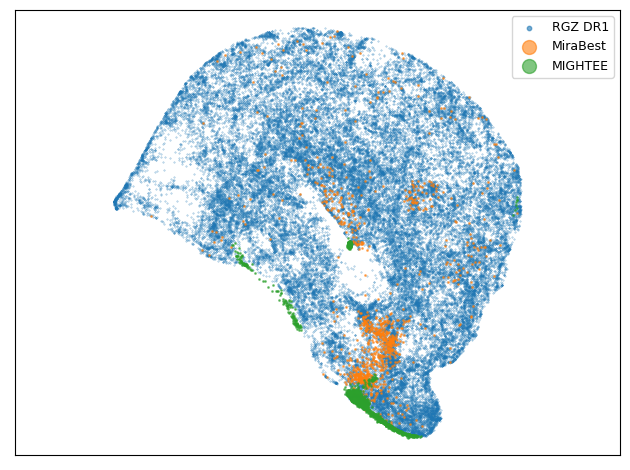

In [45]:
fig, ax = pl.subplots()
#fig.set_size_inches(fig_size)

ax.scatter(rgz_umap[:, 0], rgz_umap[:, 1], label="RGZ DR1", marker=marker, s=marker_size, alpha=alpha)
ax.scatter(mb_umap[:, 0], mb_umap[:, 1], label="MiraBest", marker=marker, s=10*marker_size, alpha=alpha)
ax.scatter(mightee_umap[:, 0], mightee_umap[:, 1], label="MIGHTEE", marker=marker, s=10*marker_size, alpha=alpha)

pl.gca().set_aspect("equal", "datalim")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_xlabel("umap x", fontsize=fontsize)
ax.set_ylabel("umap y", fontsize=fontsize)
ax.legend(fontsize=fontsize, markerscale=10)
fig.tight_layout()
fig.savefig("byol_umap_mightee.png", bbox_inches="tight", pad_inches=0.05, dpi=600)

Text(0, 0.5, 'umap y')

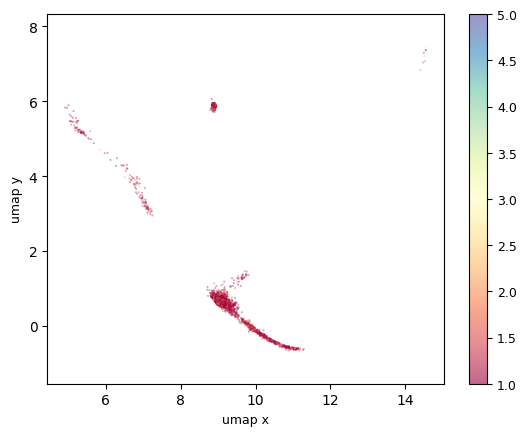

In [87]:
fig, ax = pl.subplots()

#labels = [1 if x=='True' else 0 for x in mightee_data.df['AGN'].values]
labels = mightee_data.df['Redshift'].values

scatter = ax.scatter(
    mightee_umap[:, 0],
    mightee_umap[:, 1],
    c=labels,
    cmap="Spectral",
    s=marker_size,
    marker=marker,
    vmin=1,
    vmax=5,
    alpha=alpha,
)

pl.gca().set_aspect("equal", "datalim")
cbar = fig.colorbar(scatter)
cbar.ax.tick_params(labelsize=fontsize)
ax.set_xlabel("umap x", fontsize=fontsize)
ax.set_ylabel("umap y", fontsize=fontsize)
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)

In [72]:
dict = {'mightee_name': mightee_data.df['Name'].values, 'umap_x': mightee_umap[:, 0], 'umap_y': mightee_umap[:, 1], 'ra': mightee_data.df['ra'].values, 'dec': mightee_data.df['dec'].values}
df = pd.DataFrame(dict)
df.to_parquet('mightee_umap.parquet')

In [81]:
df.head(5)
df.loc[df['mightee_name'] == 'J095906.82+020654.3']

,mightee_name,umap_x,umap_y,ra,dec
2287,J095906.82+020654.3,9.884986,0.000936,149.778,2.115
